In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision as tv
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

Скачиваем веса модели и датасет, на котором проходило обучение

In [ ]:
# Dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10QSP4MpfxE5syt6Vutp_IpNzsWFnGl3P' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10QSP4MpfxE5syt6Vutp_IpNzsWFnGl3P" -O archive.zip && rm -rf /tmp/cookies.txt # Dataset

# Discriminator Weights
!wget 'https://docs.google.com/uc?export=download&id=11eInWGWT2x_7BcptrM68M4CY0XQ6oQxo' -O d_main.zip 

# Generator Weights 
!wget 'https://docs.google.com/uc?export=download&id=11bSkJhm6FSM5D6rQvobHPf8zuM7SP8RN' -O g_main.zip 

--2021-09-25 11:36:21--  https://docs.google.com/uc?export=download&confirm=qXRi&id=10QSP4MpfxE5syt6Vutp_IpNzsWFnGl3P
Resolving docs.google.com (docs.google.com)... 209.85.147.139, 209.85.147.138, 209.85.147.102, ...
Connecting to docs.google.com (docs.google.com)|209.85.147.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-74-docs.googleusercontent.com/docs/securesc/fpl09gj0r1fi11qfkmsbdr71slihs3ii/3o178p3k6c23a4uh7s1gnupe5pa3lo8p/1632569775000/05010337546764639457/10105573726905964854Z/10QSP4MpfxE5syt6Vutp_IpNzsWFnGl3P?e=download [following]
--2021-09-25 11:36:21--  https://doc-0c-74-docs.googleusercontent.com/docs/securesc/fpl09gj0r1fi11qfkmsbdr71slihs3ii/3o178p3k6c23a4uh7s1gnupe5pa3lo8p/1632569775000/05010337546764639457/10105573726905964854Z/10QSP4MpfxE5syt6Vutp_IpNzsWFnGl3P?e=download
Resolving doc-0c-74-docs.googleusercontent.com (doc-0c-74-docs.googleusercontent.com)... 209.85.147.132, 2607:f8b0:4001:c20::84
Connecting

In [ ]:
!unzip '/content/archive.zip'

Archive:  /content/archive.zip
  inflating: images/Abomasnow/0.jpg  
  inflating: images/Abomasnow/1.jpg  
  inflating: images/Abomasnow/2.jpg  
  inflating: images/Abomasnow/3.jpg  
  inflating: images/Abra/0.jpg       
  inflating: images/Abra/1.jpg       
  inflating: images/Abra/2.jpg       
  inflating: images/Abra/3.jpg       
  inflating: images/Absol/0.jpg      
  inflating: images/Absol/1.jpg      
  inflating: images/Absol/2.jpg      
  inflating: images/Absol/3.jpg      
  inflating: images/Accelgor/0.jpg   
  inflating: images/Accelgor/1.jpg   
  inflating: images/Aegislash/0.jpg  
  inflating: images/Aegislash/1.jpg  
  inflating: images/Aegislash/2.jpg  
  inflating: images/Aegislash/3.jpg  
  inflating: images/Aerodactyl/0.jpg  
  inflating: images/Aerodactyl/1.jpg  
  inflating: images/Aerodactyl/2.jpg  
  inflating: images/Aerodactyl/3.jpg  
  inflating: images/Aerodactyl/4.jpg  
  inflating: images/Aerodactyl/5.jpg  
  inflating: images/Aggron/0.jpg     
  inflating: 

In [ ]:
for dirname, _, filenames in os.walk('images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

images/Flapple/1.jpg
images/Flapple/0.jpg
images/Liepard/1.jpg
images/Liepard/0.jpg
images/Mudkip/1.jpg
images/Mudkip/2.jpg
images/Mudkip/0.jpg
images/Mudkip/3.jpg
images/Servine/1.jpg
images/Servine/0.jpg
images/Walrein/1.jpg
images/Walrein/0.jpg
images/Azelf/1.jpg
images/Azelf/0.jpg
images/Scrafty/1.jpg
images/Scrafty/0.jpg
images/Delcatty/1.jpg
images/Delcatty/0.jpg
images/Terrakion/1.jpg
images/Terrakion/0.jpg
images/Pincurchin/0.jpg
images/Vanilluxe/1.jpg
images/Vanilluxe/0.jpg
images/Hitmonchan/1.jpg
images/Hitmonchan/2.jpg
images/Hitmonchan/0.jpg
images/Hitmonchan/3.jpg
images/Tropius/1.jpg
images/Tropius/0.jpg
images/Feebas/1.jpg
images/Feebas/0.jpg
images/Tentacruel/1.jpg
images/Tentacruel/2.jpg
images/Tentacruel/0.jpg
images/Tentacruel/3.jpg
images/Hydreigon/1.jpg
images/Hydreigon/0.jpg
images/Ninjask/1.jpg
images/Ninjask/0.jpg
images/Wailmer/1.jpg
images/Wailmer/0.jpg
images/Luvdisc/1.jpg
images/Luvdisc/0.jpg
images/Chikorita/1.jpg
images/Chikorita/2.jpg
images/Chikorita/0.j

In [ ]:
DATA_DIR = './images/'

Обрежем изображения до размера image_size, добавим изменение оттенка с помощью tv.transforms.ColorJitter(hue=0.5), горизонтальный поворот с вероятностью 0.5, а также нормализуем по каждому каналу с параметрами stats.

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tv.transforms.ColorJitter(hue=0.5),
    tt.CenterCrop(image_size),
    tt.RandomHorizontalFlip(), 
    tt.ToTensor(),
    tt.Normalize(*stats)]))


In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=16).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим на картинки, которые лежат в датасете

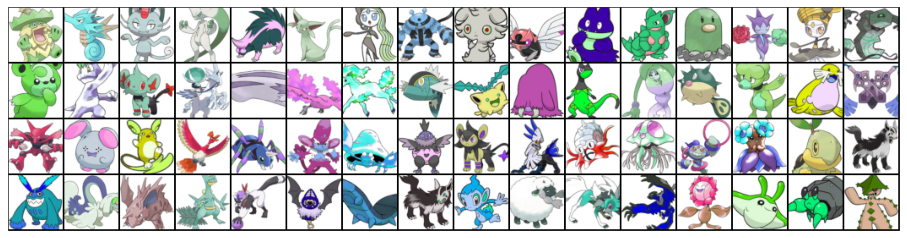

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Дискриминатор будет брать входное изображение размером (3 x image_size x image_size), обрабатывать его через серию слоев Conv2d, BatchNorm2d и LeakyReLU и выводить вероятность того, что изображение является раельным с помощью функции активации сигмоиды

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

Попробовав обучать модель с размером латентного пространства от 16 до 100, я пришел к выводу, что лучше всего модель ведет себя, если размерность латентного пространства равна 16

In [ ]:
latent_size = 16

Генератор предназначен для того, чтобы переводить вектор из латентного пространства в пространство изображений (т.е. 3 x image_size x image_size). Для этого будем использовать серию последовательных двумерных сверточных слоев транспонирования, каждый из которых сопряжен со слоем 2d-пакетной нормы и активацией relu. Выход генератора подается через функцию tanh, чтобы вернуть его в диапазон входных данных [-1,1].

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Вот что выдает генератор до обучения - просто шум

torch.Size([128, 3, 64, 64])


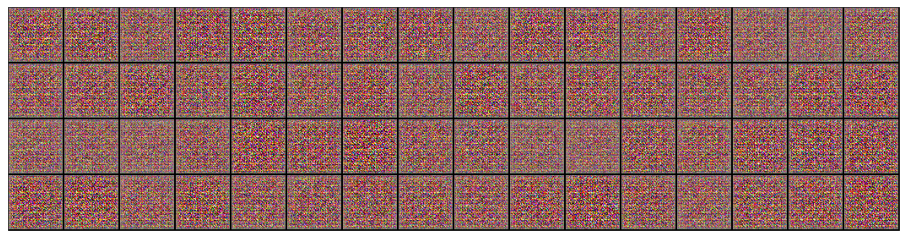

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

Сама модель состоит из генератора и дискриниматора, а процесс обучения просиходит следующим образом: 

1) Берем выборку из реальных изображений размера batch_size и прогоняем ее через дискриминатор, тем самым получим вероятности того, что картинки реальные.После этого присваиваем всем этим картинкам класс 1 и считаем real_loss.

2) Аналогично генерируем фейковые изображения генератором и присваиваем этим картинкам класс 0, пропускаем их через дискриминатор. После этого считаем fake_loss.

3) Обновляем веса дискриниматора, учитывая, что loss_d дискрининатора состоит из real_loss + fake_loss.

До этого момента веса генератора никак не обновлялись, а на следующих шагах не будут обновляться веса дискриминатора. Соответственно у генератора и дискриминатора свои оптимизаторы.

4) Генерируем выборку фейковых изображений генератором и присваиваем им класс 1, то есть пытаемся "обмануь" дискриминатор.

5) Пропускаем полученную выборку через дискриминатор и считаем loss_g, после чего обновляем веса генератора.

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        
        # If collab crash 
        #if epoch % 50 == 0:
          #torch.save(model['discriminator'].state_dict(), f'/content/drive/MyDrive/dls/d_{int(epoch/50)}.zip')
          #torch.save(model['generator'].state_dict(), f'/content/drive/MyDrive/dls/g__{int(epoch/50)}.zip')
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

lr = 0.0002
epochs = 300

# Load model weights
if device == torch.device('cuda'):
  model['discriminator'].load_state_dict(torch.load('/content/d_main.zip'))
  model['generator'].load_state_dict(torch.load('/content/g_main.zip'))
else:
  model['discriminator'].load_state_dict(torch.load('/content/d_main.zip', map_location=torch.device('cpu')))
  model['generator'].load_state_dict(torch.load('/content/g_main.zip', map_location=torch.device('cpu')))



<All keys matched successfully>

Посмотрим на изображения, которые научился строить генератор спустя примерно 1800 эпох, примерно, потому что обучение я делал в несколько этапов в силу лимитов colab на gpu, то есть сохранял веса модели и заспускал обучение снова уже на другом аккаунте и т.д. В целом результаты очень интересные, некоторые изображения походят на реальных покемонов!

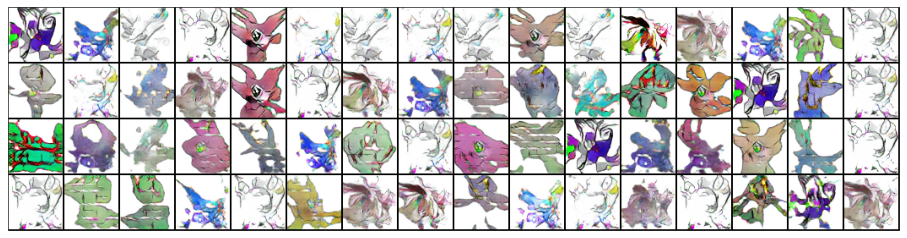

In [ ]:
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = model["generator"](latent)
show_images(fake_images.to(torch.device('cpu')))

Интересно посмотреть на то, какие изображения получаются, если взять выпуклую оболочку двух латентных векторов.

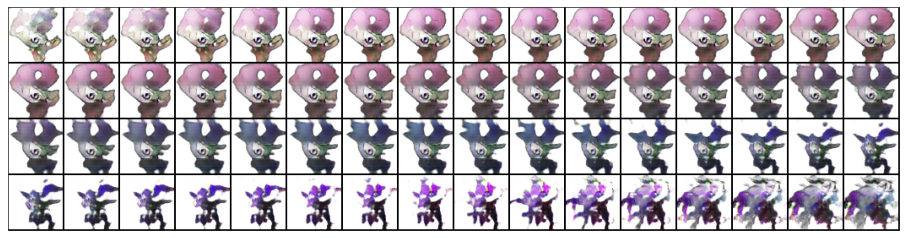

In [ ]:
convex_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
latent1 = torch.randn(1, latent_size, 1, 1, device=device)
latent2 = torch.randn(1, latent_size, 1, 1, device=device)
for i, alpha in enumerate(np.linspace(0., 1., 16*4)):
  convex_latent[i] = alpha*latent1 + (1 - alpha)*latent2
fake_images = model["generator"](convex_latent)
show_images(fake_images.to(torch.device('cpu')))

Дальнейший код - запуск обучения и постороение графиков Losses и Scores. Я специально вынес его в конец, чтобы сначала посмотреть на получившиеся результаты.

In [ ]:
epochs = 10 
history = fit(model, criterion, epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 18.2338, loss_d: 0.0044, real_score: 0.9982, fake_score: 0.0022


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 16.8962, loss_d: 0.0025, real_score: 0.9988, fake_score: 0.0011


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 15.9886, loss_d: 0.1078, real_score: 0.9726, fake_score: 0.0161


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 14.9153, loss_d: 0.0118, real_score: 0.9997, fake_score: 0.0083


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 12.9076, loss_d: 0.0098, real_score: 0.9968, fake_score: 0.0048


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 11.5176, loss_d: 0.0089, real_score: 0.9969, fake_score: 0.0048


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 10.1474, loss_d: 0.0102, real_score: 0.9961, fake_score: 0.0038


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 12.3516, loss_d: 0.0082, real_score: 0.9968, fake_score: 0.0040


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 12.0528, loss_d: 0.0045, real_score: 0.9979, fake_score: 0.0023


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 11.5811, loss_d: 0.0060, real_score: 0.9972, fake_score: 0.0025


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

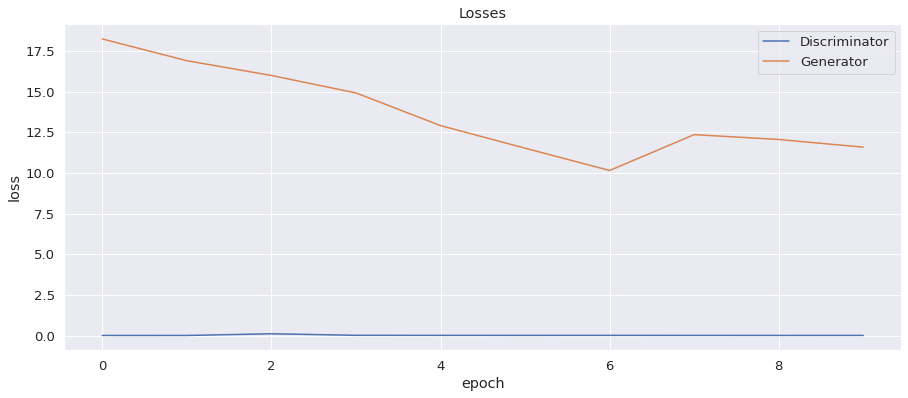

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

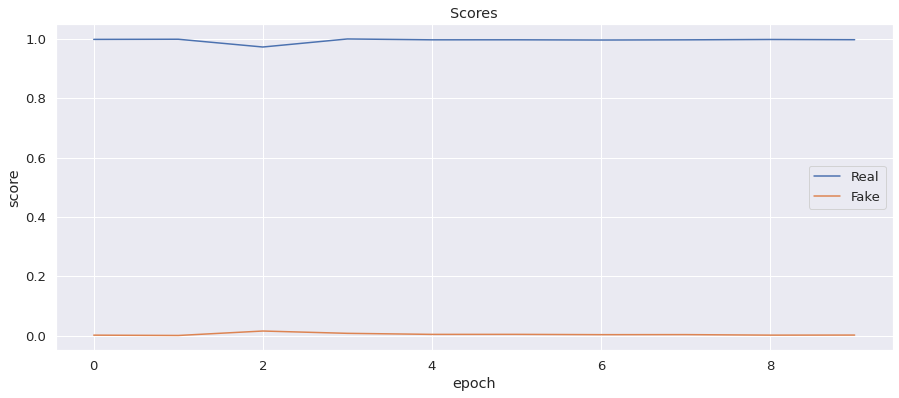

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');